# Train with time-300B 

We'll  training the two architectures (LSTM and Neural ODE) using time-300B taking windows of 7, 14 and 21 sequenses.

This will be the experiments that we are going to do for both architectures:

- Baseline $100 \%$ of dataset

- Baseline $10 \%$ of dataset

- Baseline $3 \%$ of dataset

- Destillation with Time-Moe $3 \%$ of dataset

In [1]:
# Cargar la data
# Seleccionar las ventanas de cada sequencia de serie
# Dividir el porcentaje con muestreos (Separar 80-20)
# Entrenar los modelos
# Hacer destilación


### Load data

In [1]:
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from Time_MoE.time_moe.datasets.time_moe_dataset import TimeMoEDataset
from sklearn.model_selection import train_test_split
# Importing custom functions
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

from baseline.functions import load_data,create_intervals,create_windows,smape,smape_chunked,sample_fraction
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_data_clean():
    ds = TimeMoEDataset(data_folder='Time-300B\healthcare',normalization_method='zero')

    verbose = True
    total = len(ds)
    valid_indices = []
    # Iterar y filtrar
    for i in range(total):
        try:
            seq = ds[i]  # seq es numpy.ndarray según comprobaste
        except Exception as e:
            # Si hay error al obtener la secuencia, lo avisamos y saltamos
            if verbose:
                print(f"Advertencia: no se pudo obtener ds[{i}]: {e}")
            continue
        
        # Comprobación: si todos los valores son NaN, lo descartamos
        # seq es numpy.ndarray; cuidado si dims especiales, pero np.isnan funcionará elementwise.
        try:
            if not np.all(np.isnan(seq)):
                valid_indices.append(i)
        except Exception as e:
            # En caso de que seq no sea array puro, convertir primero:
            try:
                arr = np.array(seq)
                if not np.all(np.isnan(arr)):
                    valid_indices.append(i)
            except Exception as e2:
                if verbose:
                    print(f"Error al verificar NaN en secuencia índice {i}: {e2}")
                # Decidir si incluirla o no. Aquí optamos por descartarla:
                continue
    
    valid_count = len(valid_indices)
    if verbose:
        print(f"Secuencias totales en ds: {total}")
        print(f"Secuencias válidas (no todo NaN): {valid_count}")
        print(f"Secuencias descartadas: {total - valid_count}")
        sequences_validas = []

    for idx in valid_indices:
        try:
            sequences_validas.append(ds[idx])
        except Exception as e:
            if verbose:
                print(f"Error al extraer ds[{idx}] después de filtrar: {e}")
            # Podrías decidir saltar o detener. Aquí solo saltamos.
    return sequences_validas

def create_windows_from_sequences(sequences, window_size=15, horizon=1):
    """
    Dada una lista de secuencias (numpy arrays 1D), crea ventanas deslizantes:
    - X: array de shape (num_samples, window_size, 1)
    - y: array de shape (num_samples,)
    Cada muestra usa window_size pasos para predecir el siguiente valor (horizon=1).
    """
    X_list = []
    y_list = []
    for seq in sequences:
        # Asegurar numpy array
        arr = np.array(seq).astype(float)
        T = arr.shape[0]
        # Solo si la longitud es mayor que window_size + horizon - 1
        if T >= window_size + horizon:
            for start in range(0, T - window_size - horizon + 1):
                window = arr[start:start+window_size]
                target = arr[start+window_size:start+window_size+horizon]
                # Para horizon=1, target es un array de longitud 1; tomamos el escalar
                X_list.append(window.reshape(window_size, 1))
                y_list.append(target[0] if horizon == 1 else target)
    if len(X_list) == 0:
        return np.empty((0, window_size, 1)), np.empty((0,))
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)

    # Supongamos X tiene forma (N, window_size, 1), y y forma (N,)
    mask_valid = ~np.isnan(X).any(axis=(1,2)) & ~np.isnan(y)
    # Mantener solo muestras sin NaN:
    X_clean = X[mask_valid]
    y_clean = y[mask_valid]
    print("De", X.shape[0], "muestras, quedan", X_clean.shape[0], "sin NaN")

    return X_clean, y_clean

def build_lstm_model(window_size=15, n_features=1, lstm_units=50):
    model = Sequential([
        LSTM(lstm_units, input_shape=(window_size, n_features)),
        Dense(1)  # para predicción de un valor escalar siguiente
    ])
    model.compile(optimizer='adam', loss='mse')
    return model
def smape_2(y_true, y_pred, eps=1e-8):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    return 100 * np.mean(numerator / (denominator + eps))

In [2]:
ds = load_data_clean()

X, y = create_windows_from_sequences(ds, window_size=15, horizon=1)

Secuencias totales en ds: 1752
Secuencias válidas (no todo NaN): 1752
Secuencias descartadas: 0
De 433317 muestras, quedan 433317 sin NaN


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### LSTM - 100 %

In [4]:
# Suponiendo que X_train, y_train, X_val, y_val están listos:
model = build_lstm_model(window_size=15, n_features=1, lstm_units=50)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es]
)


Epoch 1/20


c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10833/10833 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 0.3003 - val_loss: 0.2613
Epoch 2/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 0.2665 - val_loss: 0.2572
Epoch 3/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2620 - val_loss: 0.2492
Epoch 4/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.2556 - val_loss: 0.2474
Epoch 5/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2556 - val_loss: 0.2456
Epoch 6/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2498 - val_loss: 0.2456
Epoch 7/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2555 - val_loss: 0.2445
Epoch 8/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2537 - val_loss: 0.2446
Epoch 9/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2485 - val_loss: 0.2437
Epoch 10/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2501 - val_loss: 0.2468
Epoch 11/20
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.2465 - val_loss: 0.2440
Epoch 12

## Resultados de modelo LSTM 100% sobre el conjunto de validación

In [5]:
# Evaluar en conjunto de validación

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
#smape_value = smape_new(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
#print("SMAPE:", smape_value)

2709/2709 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MAE: 0.26638794882572014
MSE: 0.24324309028574692


In [6]:
smape_val = smape_chunked(y_val, y_pred, chunk_size=500_000)
print("SMAPE:", smape_val)

SMAPE: 54.72695734387981


In [ ]:
# Guardar el modelo entrenado
model.save('Models_lstm/lstm_healthcare_model_100.keras')

### LSTM - 10 %



In [ ]:
# function to take only a percentage of the data
X_10, y_10 = sample_fraction(X, y, 0.10, random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_10, y_10, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Suponiendo que X_train, y_train, X_val, y_val están listos:
model = build_lstm_model(window_size=15, n_features=1, lstm_units=50)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/20


c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1084/1084 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3657 - val_loss: 0.2746
Epoch 2/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2964 - val_loss: 0.2593
Epoch 3/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2817 - val_loss: 0.2501
Epoch 4/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2538 - val_loss: 0.2524
Epoch 5/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2723 - val_loss: 0.2501
Epoch 6/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2532 - val_loss: 0.2478
Epoch 7/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2554 - val_loss: 0.2491
Epoch 8/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2509 - val_loss: 0.2480
Epoch 9/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2599 - val_loss: 0.2465
Epoch 10/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2604 - val_loss: 0.2463
Epoch 11/20
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2602 - val_loss: 0.2498
Epoch 12/20
1084/1084 ━━━━━━━━━━━━━━━━━━━

## Resultados de modelo LSTM 10% sobre el conjunto de validación

In [16]:
# Evaluar en conjunto de validación

y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
smape_val = smape_chunked(y_val, y_pred, chunk_size=500_000)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 0.28106132670530165
MSE: 0.24634181455920554
SMAPE: 59.27840290397485


In [17]:
# Guardar el modelo entrenado
model.save('Models_lstm/lstm_healthcare_model_10.keras')

### LSTM - 3 %

In [18]:
X_3, y_3   = sample_fraction(X, y, 0.03, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_3, y_3, test_size=0.2, shuffle=True, random_state=42)

In [19]:
# Suponiendo que X_train, y_train, X_val, y_val están listos:
model = build_lstm_model(window_size=15, n_features=1, lstm_units=50)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/20


c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4545 - val_loss: 0.3020
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3038 - val_loss: 0.3009
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2906 - val_loss: 0.2900
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2798 - val_loss: 0.2832
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2763 - val_loss: 0.2773
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2563 - val_loss: 0.2736
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2638 - val_loss: 0.2709
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2461 - val_loss: 0.2654
Epoch 9/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2549 - val_loss: 0.2638
Epoch 10/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2619 - val_loss: 0.2634
Epoch 11/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2447 - val_loss: 0.2621
Epoch 12/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

## Resultados de modelo LSTM 3% sobre el conjunto de validación

In [20]:
# Evaluar en conjunto de validación

y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
smape_val = smape_chunked(y_val, y_pred, chunk_size=500_000)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 0.28537223200023826
MSE: 0.2600540885694726
SMAPE: 59.34711632361779


In [21]:
# Guardar el modelo entrenado
model.save('Models_lstm/lstm_healthcare_model_3.keras')

### LSTM Distillation 

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Load time_moe
X_3, y_3   = sample_fraction(X, y, 0.03, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_3, y_3, test_size=0.2, shuffle=True, random_state=42)

In [6]:
# Teacher prediction using Time-MoE
from transformers import AutoModelForCausalLM
import torch
import numpy as np    

model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map="cpu",  # use "cpu" for CPU inference, and "cuda" for GPU inference.
    trust_remote_code=True,
)

train_predict_teacher = []
val_predict_teacher = []

for arr,y in zip(X_train,y_train):                   
    t = torch.from_numpy(arr.reshape(1, 15)).float()
    mean = t.mean(dim=-1, keepdim=True)   # (1,1)
    std  = t.std(dim=-1, keepdim=True)    # (1,1)
    std = std.clamp(min=1e-6) # Evitar división por cero
    normed_seq = (t - mean) / std         # (1,15)
    output = model.generate(normed_seq, max_new_tokens=1)  
    normed_pred = output[:, -1:]            # (1,1)
    pred = normed_pred * std + mean         # (1,1)
    train_predict_teacher.append(pred.item())  # Guardar las predicciones desnormalizadas

for arr in X_val:                   
    t = torch.from_numpy(arr.reshape(1, 15)).float()
    mean = t.mean(dim=-1, keepdim=True)   # (1,1)
    std  = t.std(dim=-1, keepdim=True)    # (1,1)
    std = std.clamp(min=1e-6) # Evitar división por cero
    normed_seq = (t - mean) / std         # (1,15)
    output = model.generate(normed_seq, max_new_tokens=1)  
    normed_pred = output[:, -1:]            # (1,1)
    pred = normed_pred * std + mean         # (1,1)
    val_predict_teacher.append(pred.item())  # Guardar las predicciones desnormalizadas

C:\Users\criju\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0724 14:17:05.563000 19540 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
C:\Users\criju\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# Convert the predictions to numpy arrays
# r_t_train = np.vstack([t.cpu().numpy().reshape(-1,1) for t in train_predict_teacher])
# r_t_val   = np.vstack([t.cpu().numpy().reshape(-1,1) for t in val_predict_teacher])

r_t_train =  np.array(train_predict_teacher).reshape(-1,1)
r_t_val   =  np.array(val_predict_teacher).reshape(-1,1)

In [9]:
t_train = np.array(y_train).reshape(-1,1)
t_val   = np.array(y_val).reshape(-1,1)

In [10]:
# Save teacher results for train and validation sets
import os
import csv

os.makedirs('teacher_results', exist_ok=True)

with open('teacher_results/val_teacher.csv', mode='w', newline='') as archivo:
    escritor = csv.writer(archivo)
    escritor.writerows(r_t_val)

with open('teacher_results/train_teacher.csv', mode='w', newline='') as archivo:
    escritor = csv.writer(archivo)
    escritor.writerows(r_t_train)


In [11]:
# --- 3) Calcula σ y ε según el paper (ec.3) usando MAD sobre (t - r_t_train) ---
import numpy as np

# 1) calcula mad y sigma como antes
xi    = t_train - r_t_train
mad   = np.median(np.abs(xi - np.median(xi)))
sigma = 1.4826 * mad

# 2) elige tu alpha
alpha = 1.0

# 3) evita nan clippeando el ratio a <1
ratio = alpha / (np.sqrt(2*np.pi) * sigma)
ratio = min(ratio, 1 - 1e-6)

# 4) calcula epsilon sin miedo a nan
epsilon = sigma * np.sqrt(-2.0 * np.log(ratio))

print(f"σ = {sigma:.4f}, ratio = {ratio:.4f}, ε = {epsilon:.4f}")


σ = 0.1869, ratio = 1.0000, ε = 0.0003


In [12]:
# --- 4) Construye el student model de nuevo (dos salidas) ---
window_size, n_features, lstm_units = 15, 1, 50
inp = Input(shape=(window_size, n_features))
x   = LSTM(lstm_units)(inp)
out_clean   = Dense(1, name="clean_output")(x)   # Rs
out_teacher = Dense(1, name="teacher_output")(x) # Rd
student = Model(inp, [out_clean, out_teacher])

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense

@tf.keras.utils.register_keras_serializable(package="CustomModels")
class StudentTOR(Model):
    def __init__(
        self,
        window_size: int,
        n_features: int,
        lstm_units: int,
        epsilon: float,
        c_tor: float = 1.0,
        c_dist: float = 1.0,
        **kwargs
    ):
        super().__init__(**kwargs)
        # Guardamos los hiperparámetros para serializar
        self.window_size = window_size
        self.n_features  = n_features
        self.lstm_units  = lstm_units
        self.epsilon     = epsilon
        self.c_tor       = c_tor
        self.c_dist      = c_dist
        self.tor_metric   = tf.keras.metrics.Mean(name="tor_loss")
        self.dist_metric  = tf.keras.metrics.Mean(name="distill_loss")
        self.lstm = LSTM(
            lstm_units,
            input_shape=(window_size, n_features),
            name="lstm_layer"
        )
        self.dense_clean   = Dense(1, name="clean_output")
        self.dense_teacher = Dense(1, name="teacher_output")

    def call(self, inputs, training=False):
        x = self.lstm(inputs)
        return self.dense_clean(x), self.dense_teacher(x)

    def compute_tor_loss(self, t, r_t_gt, Rs):
        err = tf.abs(t - r_t_gt)
        clean_loss   = tf.square(Rs - t)
        outlier_loss = tf.sqrt(tf.abs(Rs - r_t_gt) + 1e-6)
        return tf.where(err < self.epsilon, clean_loss, outlier_loss)

    def train_step(self, data):
        x, y = data
        t      = y[:, 0:1]   # etiqueta real
        r_t_gt = y[:, 1:2]   # pred teacher

        with tf.GradientTape() as tape:
            Rs, Rd = self(x, training=True)
            L_tor  = tf.reduce_mean(self.compute_tor_loss(t, r_t_gt, Rs))
            L_dist = tf.reduce_mean(tf.abs(Rd - r_t_gt))
            loss   = self.c_tor * L_tor + self.c_dist * L_dist

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(t, Rs)

        self.tor_metric.update_state(L_tor)
        self.dist_metric.update_state(L_dist)

        return {
            "loss": loss,
            "tor_loss": self.tor_metric.result(),
            "distill_loss": self.dist_metric.result(),
            "mse": self.metrics[0].result(),   # asumiendo que el primer self.metrics es MSE
        }

    def test_step(self, data):
        x, y = data
        t      = y[:, 0:1]
        r_t_gt = y[:, 1:2]
        Rs, Rd = self(x, training=False)

        L_tor  = tf.reduce_mean(self.compute_tor_loss(t, r_t_gt, Rs))
        L_dist = tf.reduce_mean(tf.abs(Rd - r_t_gt))
        loss   = self.c_tor * L_tor + self.c_dist * L_dist

        self.compiled_metrics.update_state(t, Rs)
        return {
            "loss": loss,
            "tor_loss": L_tor,
            "distill_loss": L_dist,
            **{m.name: m.result() for m in self.metrics}
        }

    def get_config(self):
        # Devuelve todo lo necesario para reconstruir la instancia
        base_config = super().get_config()
        return {
            **base_config,
            "window_size": self.window_size,
            "n_features":  self.n_features,
            "lstm_units":  self.lstm_units,
            "epsilon":     self.epsilon,
            "c_tor":       self.c_tor,
            "c_dist":      self.c_dist,
        }

    @classmethod
    def from_config(cls, config):
        # Separar kwargs de Model (si los hubiera)
        return cls(
            window_size=config.pop("window_size"),
            n_features=config.pop("n_features"),
            lstm_units=config.pop("lstm_units"),
            epsilon=config.pop("epsilon"),
            c_tor=config.pop("c_tor"),
            c_dist=config.pop("c_dist"),
            **config
        )


In [81]:
# 1) Calcula epsilon como antes
#    (usando MAD sobre t_train - r_t_train)
# 2) Prepara y_true concatenado:
y_true_train = np.concatenate([t_train, r_t_train], axis=1)
y_true_val   = np.concatenate([t_val,   r_t_val],   axis=1)

# 3) Instantiate and compile
student = StudentTOR(
    window_size=15,
    n_features=1,
    lstm_units=50,
    epsilon=epsilon,
    c_tor=1.0,
    c_dist=1.0
)
student.compile(optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError(name="mse")])

# 4) Fit
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = student.fit(
    X_train, y_true_train,
    validation_data=(X_val, y_true_val),
    epochs=20,
    batch_size=32,
    callbacks=[es]
)


Epoch 1/20


c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:640: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - distill_loss: -0.0596 - loss: 0.5869 - mse: -0.0706 - tor_loss: -0.0556 - val_distill_loss: -0.0134 - val_loss: -0.0134 - val_tor_loss: -0.0134
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - distill_loss: -0.0052 - loss: 0.4160 - mse: -0.0083 - tor_loss: 2.8429e-04 - val_distill_loss: -0.0412 - val_loss: -0.0412 - val_tor_loss: -0.0412
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - distill_loss: 0.0040 - loss: 0.3862 - mse: 0.0017 - tor_loss: 0.0093 - val_distill_loss: -0.0387 - val_loss: -0.0387 - val_tor_loss: -0.0387
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - distill_loss: -0.0072 - loss: 0.3764 - mse: -0.0098 - tor_loss: -0.0021 - val_distill_loss: -0.0284 - val_loss: -0.0284 - val_tor_loss: -0.0284
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - distill_loss: -0.0044 - loss: 0.3684 - mse: -0.0068 - tor_loss: 7.1806e-04 - val_distill_loss: -0.0313 - val_loss: -0.0313 - val_tor_loss: -0.0313
Epoch 6/20
325/325

In [82]:
# Same names as the paper 
Rs_output, Rd_output = student.predict(X_val)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Resultados de modelo LSTM destilado sobre el conjunto de validación

In [83]:
# Evaluar en conjunto de validación
mae = mean_absolute_error(y_val, Rd_output)
mse = mean_squared_error(y_val, Rd_output)
smape_val = smape(y_val, Rd_output)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 0.3090988637417971
MSE: 0.28186754778880274
SMAPE: 67.40805956748918


## Resultados de modelo timesMOE sobre el conjunto de validación

In [74]:
#Resultados de modelos teacher sobre el conjunto de validación 
mae = mean_absolute_error(y_val, val_predict_teacher)
mse = mean_squared_error(y_val, val_predict_teacher)
smape_val = smape(y_val, val_predict_teacher)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 0.29947147856463113
MSE: 0.2808381897192965
SMAPE: 30.35469758164513


In [36]:
student.save('Models_lstm/lstm_healthcare_model_3_destilation.keras')

In [37]:
# Luego, para cargar sin errores:
lstm_model = tf.keras.models.load_model(
    "Models_lstm/lstm_healthcare_model_3_destilation.keras",
    compile=False
)
lstm_model.summary()

c:\Users\criju\.conda\envs\ts\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "student_tor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer (LSTM)               │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clean_output (Dense)            │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ teacher_output (Dense)          │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,502 (41.02 KB)

 Trainable params: 10,502 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
y_val

array([ 1.54375505, -2.75533152, -1.20078635, ..., -0.39933625,
       -0.17729302, -0.86397123])

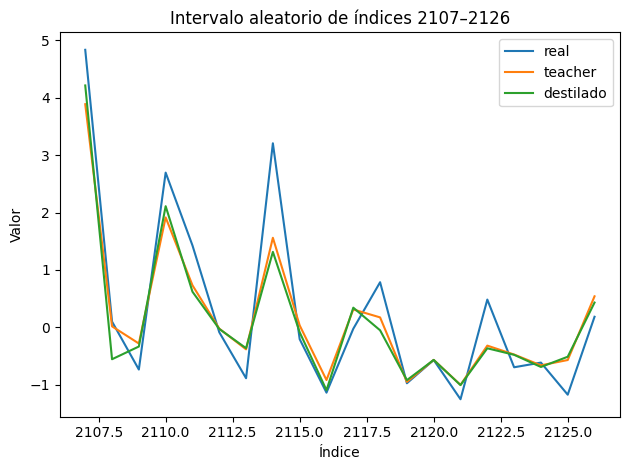

In [72]:
import random
import matplotlib.pyplot as plt

# Tus listas originales:
# y_val, r_t_val, Rd_output , y_val_normalized

# Asegúrate de que todas tengan la misma longitud n ≥ 20
n = len(y_val)

# Elige un índice de inicio aleatorio tal que haya espacio para 20 puntos
inicio = random.randint(0, n - 20)
fin = inicio + 20

# Crea un eje X con los índices reales para ese intervalo
x = list(range(inicio, fin))

# Extrae los subrangos de cada serie
y_segmento     = y_val[inicio:fin]
teacher_segmento = r_t_val[inicio:fin]
destilado_segmento = Rd_output[inicio:fin]

# Grafica solo el intervalo seleccionado
plt.figure()
plt.plot(x, y_segmento,         label='real')
plt.plot(x, teacher_segmento,   label='teacher')
plt.plot(x, destilado_segmento, label='destilado')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title(f'Intervalo aleatorio de índices {inicio}–{fin-1}')
plt.legend()
plt.tight_layout()
plt.show()


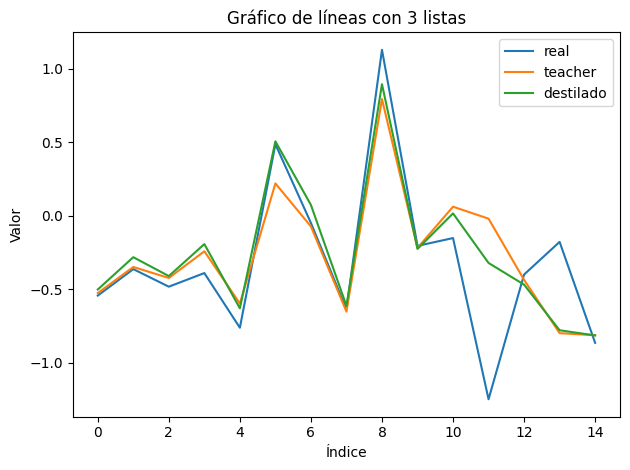

In [100]:
# Grafica, LSTM_Destilado vs Time-MoE 
import matplotlib.pyplot as plt

# Supongamos que ya tienes tres listas de igual longitud:

# Si no te interesa un eje X personalizado, Matplotlib usará el índice (0,1,2,…).
plt.figure()
plt.plot(y_val[-15:], label='real')
plt.plot(r_t_val[-15:], label='teacher')
plt.plot(Rd_output[-15:], label='destilado')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Gráfico de líneas con 3 listas')
plt.legend()   # Muestra la leyenda para identificar cada serie
plt.tight_layout()
plt.show()



In [101]:
#Resultados de modelos teacher sobre el conjunto de validación 
smape_val_1 = smape_2(y_val[-15:], lista_simple[-15:])
smape_val_2 = smape_2(y_val[-15:], Rd_output[-15:])
print("SMAPE:", smape_val_1)
print("SMAPE:", smape_val_2)

SMAPE: 26.20173636959452
SMAPE: 55.7494740333207


In [106]:
rd_1=np.array(Rd_output[-15:])

In [110]:
rd_1=rd_1.flatten()
rd_1.shape

(15,)

In [111]:
rd_1

array([-0.50102174, -0.28138626, -0.40984172, -0.19238874, -0.6288726 ,
        0.5065238 ,  0.07375443, -0.61216855,  0.89487964, -0.22521794,
        0.01634705, -0.3206721 , -0.46794587, -0.77819055, -0.8134529 ],
      dtype=float32)

In [113]:
lista_22 = np.array(lista_simple[-15:])

In [114]:
lista_22

array([-0.525514  , -0.3479463 , -0.42276824, -0.24125543, -0.5965776 ,
        0.22013086, -0.07243088, -0.65142924,  0.7938616 , -0.21842237,
        0.061975  , -0.01944339, -0.43582696, -0.7978048 , -0.8121386 ],
      dtype=float32)

In [115]:
smape = smape_2(lista_22, y_val[-15:])  # Comparar con la serie real
print(smape)

smape = smape_2(rd_1, y_val[-15:])  # Comparar con la serie real
print(smape)

26.20173636959452
28.08149576836519


In [116]:
smape = smape_2( y_val[-15:],lista_22)  # Comparar con la serie real
print(smape)

smape = smape_2( y_val[-15:],rd_1)  # Comparar con la serie real
print(smape)

26.20173636959452
28.08149576836519
